In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

In [3]:
print(df.shape)

(282, 16)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [5]:
print(df.head())

   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Suspicious Web Traffic  

In [6]:
print(df.isnull().sum())

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [7]:
df['is_suspicious'] = df['rule_names'].apply(lambda x: 0 if pd.isnull(x) or x == 'Unknown' else 1)

In [8]:
df_clf = df.drop(columns=['creation_time', 'end_time', 'src_ip', 'dst_ip', 'source.meta', 'time', 'rule_names', 'observation_name'])

In [9]:
clf_df = df_clf.copy()
for col in ['src_ip_country_code', 'protocol', 'response.code', 'source.name', 'detection_types']:
    clf_df[col] = LabelEncoder().fit_transform(clf_df[col].astype(str))

In [10]:
X = clf_df.drop(columns=['is_suspicious'])
y = clf_df['is_suspicious']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [14]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[57]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
## Time-Based Anomaly Detection

In [15]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

In [16]:
df.set_index('time', inplace=True)
traffic_by_hour = df.resample('H').size()

<ipython-input-16-542db9353a25>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic_by_hour = df.resample('H').size()


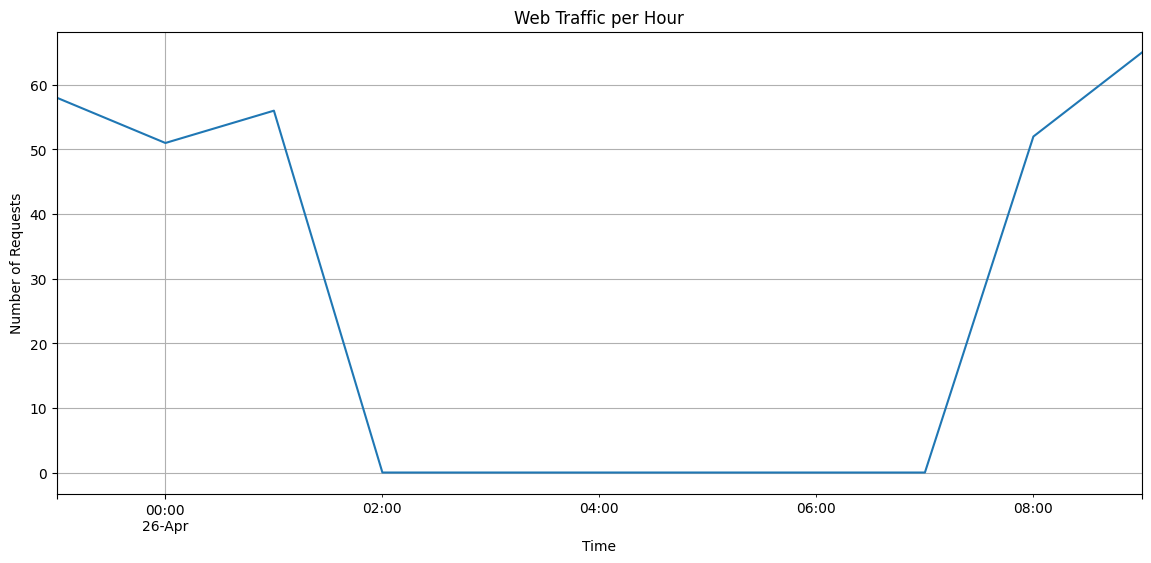

In [17]:
plt.figure(figsize=(14, 6))
traffic_by_hour.plot()
plt.title('Web Traffic per Hour')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.grid(True)
plt.show()

In [18]:
rolling_mean = traffic_by_hour.rolling(window=24).mean()
rolling_std = traffic_by_hour.rolling(window=24).std()

In [19]:
anomalies = traffic_by_hour[traffic_by_hour > (rolling_mean + 2 * rolling_std)]

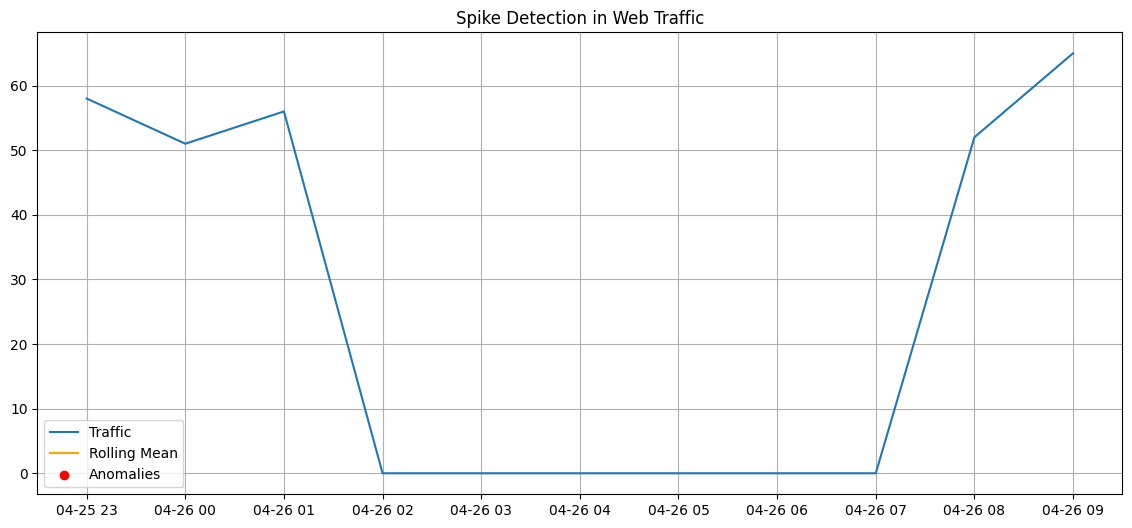

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(traffic_by_hour, label='Traffic')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('Spike Detection in Web Traffic')
plt.legend()
plt.grid(True)
plt.show()

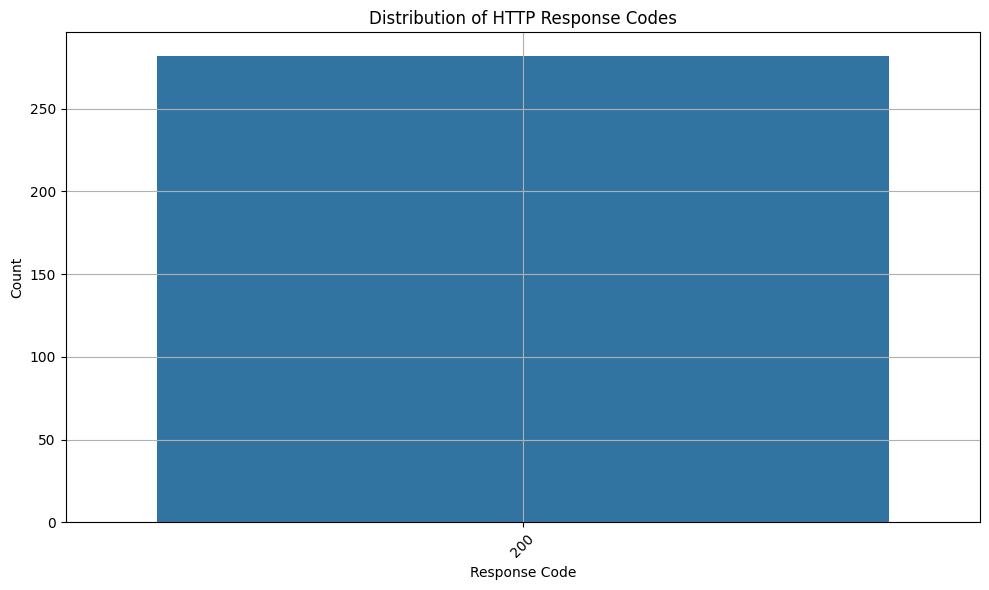

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='response.code', data=df, order=df['response.code'].value_counts().index)
plt.title('Distribution of HTTP Response Codes')
plt.xlabel('Response Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

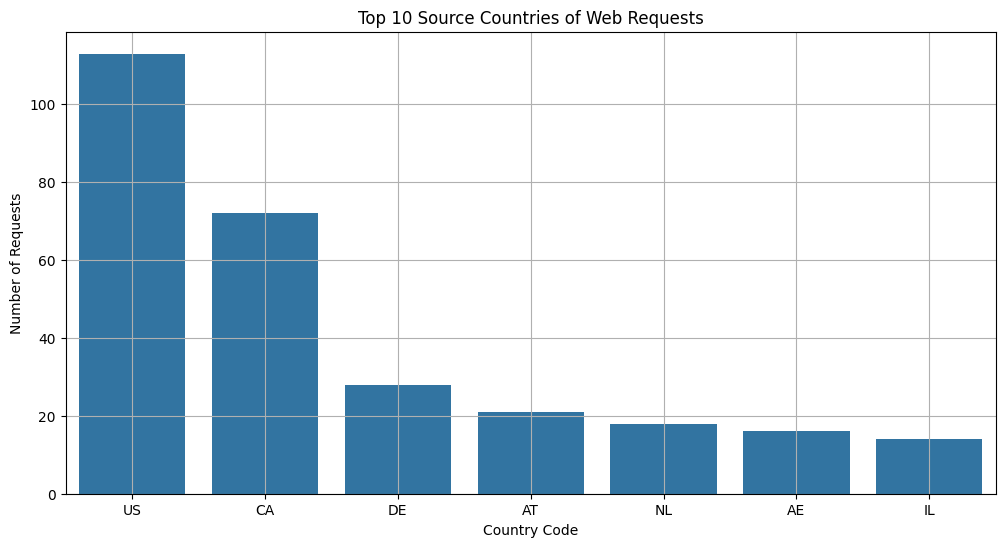

In [26]:
plt.figure(figsize=(12, 6))
top_countries = df['src_ip_country_code'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Source Countries of Web Requests')
plt.xlabel('Country Code')
plt.ylabel('Number of Requests')
plt.grid(True)
plt.show()

<ipython-input-30-0298a22b0b49>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time = df.set_index('creation_time').resample('H').size()


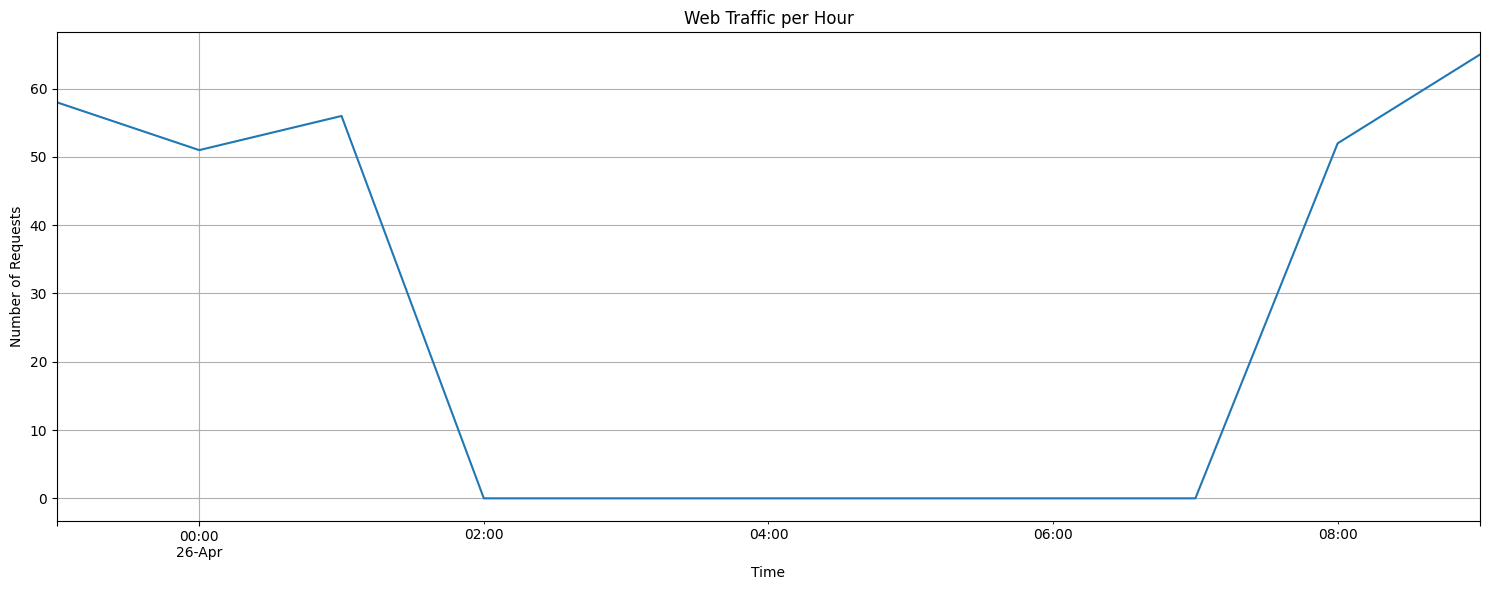

In [30]:
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df_time = df.set_index('creation_time').resample('H').size()

plt.figure(figsize=(15, 6))
df_time.plot()
plt.title('Web Traffic per Hour')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
from sklearn.ensemble import IsolationForest

# Select numeric features relevant to traffic
features = ['bytes_in', 'bytes_out']
df_model = df[features].fillna(0)

# Train the Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(df_model)

<ipython-input-37-779436ac31b2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anomaly', data=df, palette={'1': 'green', '-1': 'red'})


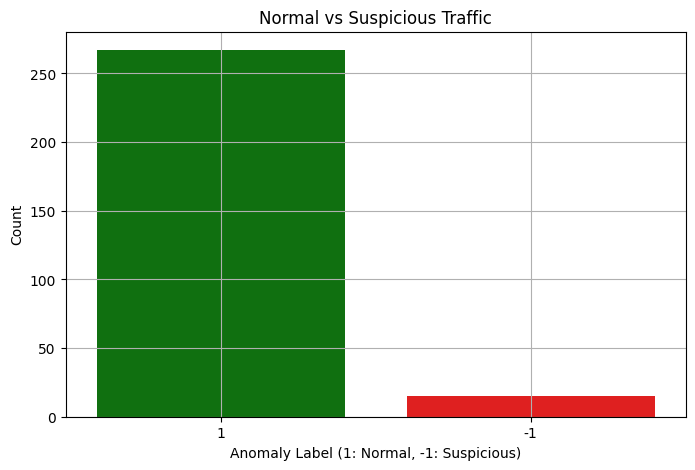

In [37]:
df['anomaly'] = df['anomaly'].astype(str)

plt.figure(figsize=(8, 5))
sns.countplot(x='anomaly', data=df, palette={'1': 'green', '-1': 'red'})
plt.title('Normal vs Suspicious Traffic')
plt.xlabel('Anomaly Label (1: Normal, -1: Suspicious)')
plt.ylabel('Count')
plt.grid(True)
plt.show()